# CINEPHILE'S CHOICE - A Genre Based Movie Recommender

In [1]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer #term frequency inverse document frequnecy
import numpy as np

# Load data from the provided Excel file
data = pd.read_excel('TeluguMovies_dataset.xlsx')

# Create a dictionary to store movies for each genre
genre_movies_dict = {}
for index, row in data.iterrows():
    genres = row['genre']
    if pd.notna(genres):
        genres = genres.split(', ')
        for genre in genres:
            genre = genre.strip()  # Remove leading and trailing spaces
            if genre not in genre_movies_dict:
                genre_movies_dict[genre] = []
            genre_movies_dict[genre].append((row['movie'], row['year'], row['rating'], row['certificate'], row['overview'], row['runtime']))

# Create a list of unique genre names (without extra spaces)
unique_genres = list(set(genre.strip() for genre in genre_movies_dict.keys()))

# Create a TF-IDF vectorizer for genre data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
genre_data = [" ".join(genre.split(', ')) for genre in unique_genres]
genre_tfidf_values = tfidf_vectorizer.fit_transform(genre_data)

# Convert the Scipy sparse matrices to dense NumPy arrays
genre_tfidf_values = genre_tfidf_values.toarray()

# Function to recommend movies based on selected genres
def recommend_movies():
    selected_genre = genre_var.get()
    
    recommended_movies = []
    
    for genre, movies in genre_movies_dict.items():
        if selected_genre in genre:
            recommended_movies.extend(movies)
    
    if recommended_movies:
        # Define a custom sorting function that considers both rating and TF-IDF values
        def custom_sort(movie):
            movie_name, year, rating, certificate, overview, runtime = movie
            genres = data[data['movie'] == movie_name]['genre'].values[0].split(', ')
            genres = [g.strip() for g in genres]  # Remove extra spaces
            genre_values = [genre_tfidf_values[unique_genres.index(g)] for g in genres]
            return (rating, np.sum(genre_values))
        
        recommended_movies.sort(key=custom_sort, reverse=True)

        # Clear the Treeview
        for item in movie_tree.get_children():
            movie_tree.delete(item)
        
        # Insert data into the Treeview
        for i, (movie, year, rating, certificate, overview, runtime) in enumerate(recommended_movies, start=1):
            if pd.notna(year):
                movie_tree.insert("", "end", values=(i, movie, int(year), rating))
            else:
                movie_tree.insert("", "end", values=(i, movie, "N/A", rating))
    
    else:
        result_label.config(text="No movies found in the selected genre.")

# Function to display movie details when a movie is selected
def display_movie_details(event):
    selected_item = movie_tree.selection()
    if selected_item:
        item = movie_tree.item(selected_item, "values")
        movie_name = item[1]
        movie_details = data[data['movie'] == movie_name]
        if not movie_details.empty:
            details_text.config(text=f"Year: {int(movie_details['year'].values[0]) if pd.notna(movie_details['year'].values[0]) else 'N/A'}\n"
                                 f"genre: {movie_details['genre'].values[0]}\n"
                                 f"Certificate: {movie_details['certificate'].values[0]}\n"
                                 f"Overview: {movie_details['overview'].values[0]}\n"
                                 f"Runtime: {movie_details['runtime'].values[0]}\n"
                                 f"rating: {movie_details['rating'].values[0]}\n"
                                 )
        else:
            details_text.config(text="Details not available for this movie.")

# Create a Tkinter window
window = tk.Tk()
window.title("Movie Recommender")

# Create a label and dropdown list for genre selection
genre_label = ttk.Label(window, text="Select Genre:")
genre_label.pack()

genre_var = tk.StringVar()
genre_dropdown = ttk.Combobox(window, textvariable=genre_var, values=unique_genres, state="readonly", justify="center")
genre_dropdown.pack()

# Create a button to recommend movies
recommend_button = ttk.Button(window, text="Recommend Movies", command=recommend_movies)
recommend_button.pack()

# Create a Treeview widget for displaying recommendations in tabular form
columns = ("Sl.No", "Movie Name", "Year", "Rating")
movie_tree = ttk.Treeview(window, columns=columns, show="headings")
for col in columns:
    movie_tree.heading(col, text=col)
    if col == "Movie Name":
        movie_tree.column(col, width=300)  # Adjust the Movie Name column width as needed
    else:
        movie_tree.column(col, width=100)  # Adjust the other column width as needed
movie_tree.pack()

# Create a label for displaying movie details
details_label = ttk.Label(window, text="Movie Details:")
details_label.pack()

details_text = ttk.Label(window, text="", wraplength=400, justify="left")
details_text.pack()

# Bind the selection event to the movie details display function
movie_tree.bind("<<TreeviewSelect>>", display_movie_details)

result_label = ttk.Label(window, text="")
result_label.pack()

window.mainloop()


###                                                         Data Visualisation

In [30]:
data.nunique()

field_1          1400
movie            1376
year               65
certificate         7
genre             170
overview         1221
runtime           112
rating             76
no.of.ratings     766
dtype: int64

### count of Genres

In [5]:
data['genre'] = data['genre'].str.strip()
genre_counts = data['genre'].str.split(', ').explode().value_counts()

print(genre_counts)

Drama        708
Action       630
Comedy       420
Romance      354
Thriller     173
Crime         84
Family        83
Musical       52
Fantasy       52
Horror        40
Adventure     33
Mystery       29
History       18
Biography     18
Sci-Fi        12
Sport         11
Animation      3
War            3
Music          2
Western        1
Name: genre, dtype: int64


## Bar Gaph for Top 15 Genres

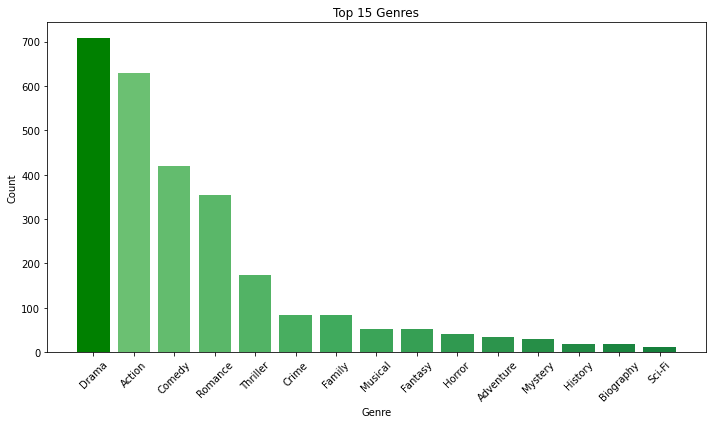

In [8]:

# Select the top 15 genres
top_15_genres = genre_counts.head(15)

# Create a color gradient from light green to dark green for the bars
colors = plt.cm.Greens(np.linspace(0.5, 0.8, len(top_15_genres)))

# Find the index of the highest count
max_count_index = top_15_genres.idxmax()

# Create a bar plot with custom colors and linewidth
plt.figure(figsize=(10, 6))
bars = plt.bar(top_15_genres.index, top_15_genres, color=colors)

# Set the linewidth of the highest bar to be thicker and fully green
bars[top_15_genres.index.get_loc(max_count_index)].set_linewidth(2)
bars[top_15_genres.index.get_loc(max_count_index)].set_facecolor('green')

plt.title('Top 15 Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


## Histogram for Movie Ratings

In [9]:
data['rating'].value_counts().sort_index(ascending=False).head(15)


9.5     1
9.2     1
9.0     1
8.9     2
8.8     4
8.7     2
8.6     3
8.5    13
8.4     6
8.3    14
8.2    21
8.1    21
8.0    21
7.9    22
7.8    32
Name: rating, dtype: int64

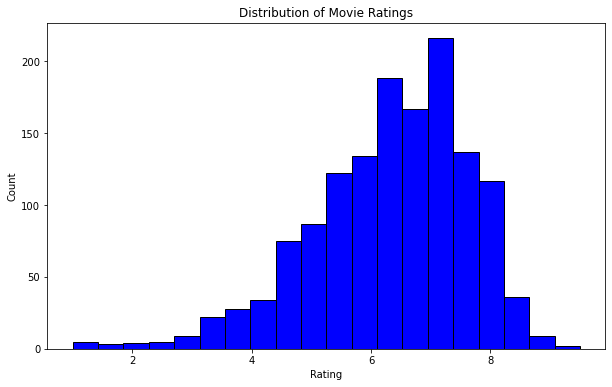

In [13]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(data['rating'], bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


## Pie Chart for Certifications

In [26]:
top_certifications = data['certificate'].value_counts()
print(top_certifications)

U            468
UA           330
A            136
Unrated        7
Not Rated      4
U/A            4
PG-13          2
Name: certificate, dtype: int64


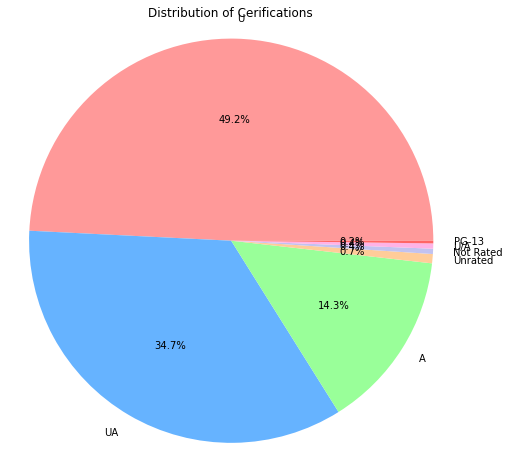

In [24]:
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_certifications, labels=top_certifications.index, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ff6666', '#c4ff4d', '#d9b3ff', '#ffcc99'])
plt.title('Distribution of Cerifications')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()


## Scatterplot for Runtime vs Ratings

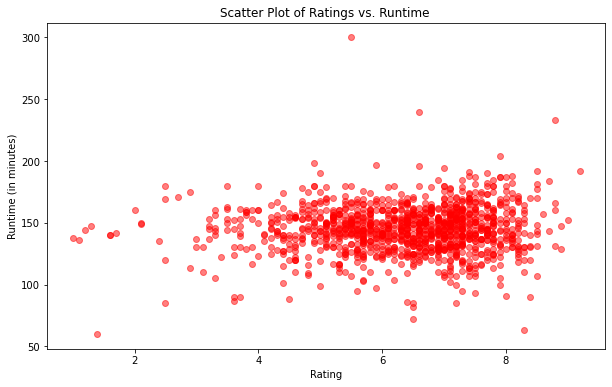

In [36]:
# Filter data to exclude movies with 0 runtime
filtered_data = data[data['runtime'] > 0]

# Create a scatter plot for ratings and runtime
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['rating'], filtered_data['runtime'], color='red', alpha=0.5)
plt.title('Scatter Plot of Ratings vs. Runtime ')
plt.xlabel('Rating')
plt.ylabel('Runtime (in minutes)')
plt.show()
